In [150]:
import numpy as np 
import pandas as pd 
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras import backend as K
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

In [121]:
train = pd.read_csv("data/train.csv", sep=",", encoding="latin1")
val = pd.read_csv("data/val.csv", sep=",", encoding="latin1")
test = pd.read_csv("data/test.csv", sep=",", encoding="latin1")
data = pd.read_csv("data/ner_dataset.csv", sep=",", encoding="latin1")

In [122]:
train.head()

,Unnamed: 0,Sentence #,Word,Tag
0,0,Sentence: 1,Italian,B-gpe
1,1,Sentence: 1,police,O
2,2,Sentence: 1,led,O
3,3,Sentence: 1,the,O
4,4,Sentence: 1,operation,O


In [123]:
val.head()

,Unnamed: 0,Sentence #,Word,Tag
0,0,Sentence: 1,The,O
1,1,Sentence: 1,Kurdish,O
2,2,Sentence: 1,party,O
3,3,Sentence: 1,has,O
4,4,Sentence: 1,fought,O


In [124]:
test.head()

,Unnamed: 0,Sentence #,Word,Tag
0,0,Sentence: 1,The,O
1,1,Sentence: 1,report,O
2,2,Sentence: 1,calls,O
3,3,Sentence: 1,on,O
4,4,Sentence: 1,President,B-per


In [125]:
data.Tag.value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  47959 non-null    object
 1   Word        1048575 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [127]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [128]:
train_getter = SentenceGetter(train)
val_getter = SentenceGetter(val)
test_getter = SentenceGetter(test)
getter = SentenceGetter(data)

In [139]:
train_sentences = [['[CLS]'] + [s[0] for s in sent] + ['[SEP]'] for sent in train_getter.sentences]
val_sentences = [['[CLS]'] + [s[0] for s in sent] + ['[SEP]'] for sent in val_getter.sentences]
test_sentences = [['[CLS]'] + [s[0] for s in sent] + ['[SEP]'] for sent in test_getter.sentences]
sentences = [['[CLS]'] + [s[0] for s in sent] + ['[SEP]'] for sent in getter.sentences]

In [140]:
print(train_sentences[0])
print(val_sentences[0])
print(test_sentences[0])

['[CLS]', 'Italian', 'police', 'led', 'the', 'operation', ',', 'arresting', '41', 'Bulgarian', 'nationals', 'in', 'Italy', ',', 'Bulgaria', ',', 'Austria', ',', 'and', 'Germany', '.', '[SEP]']
['[CLS]', 'The', 'Kurdish', 'party', 'has', 'fought', 'for', 'decades', 'for', 'the', 'creation', 'of', 'an', 'independent', 'Kurdish', 'state', 'in', 'southeastern', 'Turkey', ',', 'at', 'a', 'cost', 'of', 'at', 'least', '30,000', 'lives', '.', '[SEP]']
['[CLS]', 'The', 'report', 'calls', 'on', 'President', 'Bush', 'and', 'Congress', 'to', 'urge', 'Chinese', 'officials', 'not', 'to', 'use', 'the', 'global', 'war', 'against', 'terrorism', 'as', 'a', 'pretext', 'to', 'suppress', 'minorities', "'", 'rights', '.', '[SEP]']


In [141]:
train_labels = [['[CLS]'] + [s[1] for s in sent] + ['[SEP]'] for sent in train_getter.sentences]
val_labels = [['[CLS]'] + [s[1] for s in sent] + ['[SEP]'] for sent in val_getter.sentences]
test_labels = [['[CLS]'] + [s[1] for s in sent] + ['[SEP]'] for sent in test_getter.sentences]

In [142]:
print(train_labels[0])
print(val_labels[0])
print(test_labels[0])

['[CLS]', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'B-geo', 'O', 'B-geo', 'O', 'B-geo', 'O', 'O', 'B-geo', 'O', '[SEP]']
['[CLS]', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '[SEP]']
['[CLS]', 'O', 'O', 'O', 'O', 'B-per', 'I-per', 'O', 'B-org', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '[SEP]']


In [143]:
tags_vals = list(set(data["Tag"].values))

In [144]:
# Add X label for word piece support
# Add [CLS] and [SEP] as in BERT
tags_vals.append('X')
tags_vals.append('[CLS]')
tags_vals.append('[SEP]')
tags_vals = set(tags_vals)
tags_vals

{'B-art',
 'B-eve',
 'B-geo',
 'B-gpe',
 'B-nat',
 'B-org',
 'B-per',
 'B-tim',
 'I-art',
 'I-eve',
 'I-geo',
 'I-gpe',
 'I-nat',
 'I-org',
 'I-per',
 'I-tim',
 'O',
 'X',
 '[CLS]',
 '[SEP]'}

In [145]:
tag2idx={'B-art': 14,
 'B-eve': 16,
 'B-geo': 0,
 'B-gpe': 13,
 'B-nat': 12,
 'B-org': 10,
 'B-per': 4,
 'B-tim': 2,
 'I-art': 5,
 'I-eve': 7,
 'I-geo': 15,
 'I-gpe': 8,
 'I-nat': 11,
 'I-org': 3,
 'I-per': 6,
 'I-tim': 1,
 'X':17,
 'O': 9,
 '[CLS]':18,
 '[SEP]':19}

In [146]:
tag2name={tag2idx[key] : key for key in tag2idx.keys()}

In [147]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

train_seqs = tokenizer.texts_to_sequences(train_sentences)
val_seqs = tokenizer.texts_to_sequences(val_sentences)
test_seqs = tokenizer.texts_to_sequences(test_sentences)

In [148]:
print(train_seqs[0])
print(val_seqs[0])
print(test_seqs[0])

[2, 1119, 61, 413, 1, 479, 5, 3910, 2937, 4642, 1899, 6, 988, 5, 2842, 5, 2161, 5, 10, 438, 4, 3]
[2, 1, 597, 150, 13, 1745, 12, 870, 12, 1, 2822, 7, 26, 631, 597, 81, 6, 1332, 347, 5, 23, 9, 1334, 7, 23, 73, 2308, 1059, 4, 3]
[2, 1, 140, 484, 14, 34, 124, 10, 554, 8, 3891, 283, 37, 45, 8, 432, 1, 369, 130, 87, 536, 29, 9, 25386, 8, 11827, 4470, 316, 195, 4, 3]


In [149]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 106


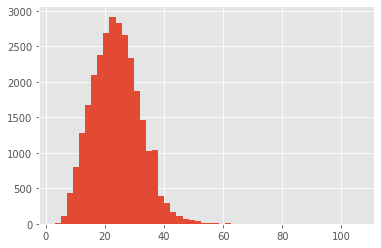

In [151]:
plt.hist([len(s) for s in train_sentences], bins=50)
plt.show()

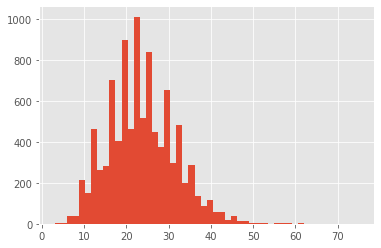

In [152]:
plt.hist([len(s) for s in val_sentences], bins=50)
plt.show()

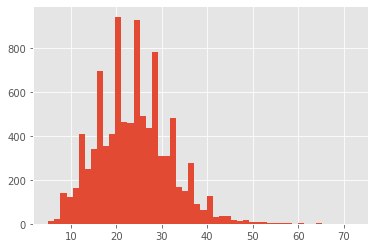

In [153]:
plt.hist([len(s) for s in test_sentences], bins=50)
plt.show()

In [157]:
words = set(data["Word"].values.tolist() + ['[CLS]', '[SEP]'])
n_words = len(words)
print(n_words)

35180


In [158]:
n_tags = 20

In [159]:
X_train = pad_sequences(train_seqs, maxlen=maxlen, dtype="long", truncating="post", padding="post")
X_val = pad_sequences(val_seqs, maxlen=maxlen, dtype="long", truncating="post", padding="post")
X_test = pad_sequences(test_seqs, maxlen=maxlen, dtype="long", truncating="post", padding="post")

In [161]:
train_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in train_labels],
                     maxlen=maxlen, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")
val_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in val_labels],
                     maxlen=maxlen, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")
test_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in test_labels],
                     maxlen=maxlen, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")

In [170]:
y_train = np.array([to_categorical(i, num_classes=n_tags) for i in train_tags])
y_val = np.array([to_categorical(i, num_classes=n_tags) for i in val_tags])
y_test = np.array([to_categorical(i, num_classes=n_tags) for i in test_tags])

In [171]:
input = Input(shape=(maxlen,))
model = Embedding(input_dim=n_words, output_dim=maxlen, input_length=maxlen)(input)
model = LSTM(units=100, return_sequences=True, input_shape=(maxlen, maxlen))(model)
out = Dense(n_tags, activation="softmax")(model)  

In [172]:
model = Model(input, out)

In [173]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 106)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 106, 106)          3729080   
_________________________________________________________________
lstm_5 (LSTM)                (None, 106, 100)          82800     
_________________________________________________________________
dense_4 (Dense)              (None, 106, 20)           2020      
Total params: 3,813,900
Trainable params: 3,813,900
Non-trainable params: 0
_________________________________________________________________


In [174]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [175]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", f1_m])

In [176]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=10, verbose=1)

D:\Anaconda\envs\tf\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 28775 samples, validate on 9592 samples
Epoch 1/10
28775/28775 [==============================] - 86s 3ms/step - loss: 0.1457 - accuracy: 0.9712 - f1_m: 0.9636 - val_loss: 0.1423 - val_accuracy: 0.9779 - val_f1_m: 0.9784
Epoch 2/10
28775/28775 [==============================] - 86s 3ms/step - loss: 0.0367 - accuracy: 0.9895 - f1_m: 0.9896 - val_loss: 0.1385 - val_accuracy: 0.9804 - val_f1_m: 0.9807
Epoch 3/10
28775/28775 [==============================] - 86s 3ms/step - loss: 0.0276 - accuracy: 0.9915 - f1_m: 0.9916 - val_loss: 0.1409 - val_accuracy: 0.9808 - val_f1_m: 0.9811
Epoch 4/10
28775/28775 [==============================] - 87s 3ms/step - loss: 0.0239 - accuracy: 0.9924 - f1_m: 0.9925 - val_loss: 0.1430 - val_accuracy: 0.9808 - val_f1_m: 0.9810
Epoch 5/10
28775/28775 [==============================] - 86s 3ms/step - loss: 0.0215 - accuracy: 0.9930 - f1_m: 0.9931 - val_loss: 0.1468 - val_accuracy: 0.9810 - val_f1_m: 0.9812
Epoch 6/10
28775/28775 [======================

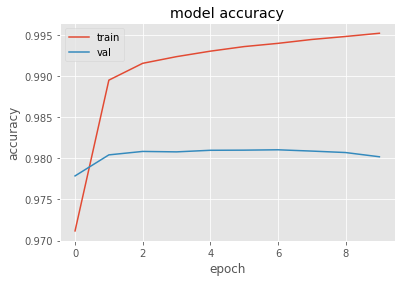

In [177]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

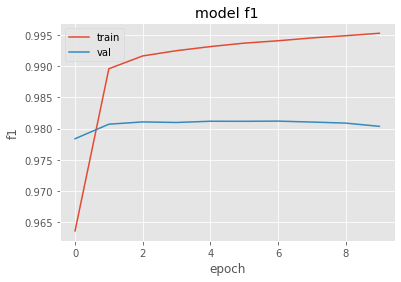

In [178]:
plt.plot(history.history["f1_m"])
plt.plot(history.history["val_f1_m"])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

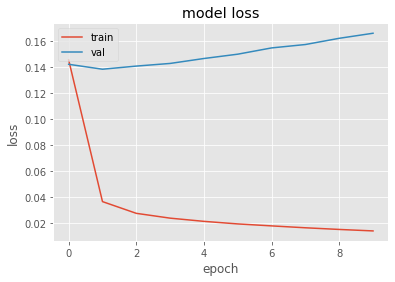

In [179]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [180]:
scores = model.evaluate(X_test, y_test, verbose=1)

9592/9592 [==============================] - 6s 669us/step


In [181]:
for i in range(len(scores)):
    print("test %s: %.2f%%" % (model.metrics_names[i], scores[i] * 100))

test loss: 17.13%
test accuracy: 97.99%
test f1_m: 98.01%
